# **Análise Exploratória de Dados das Entregas da Loggi em Brasília**

## 1\. Contexto

## **1\.** **Introdução**
Bem-vindo a esta análise exploratória de dados (EDA) das entregas realizadas pela Loggi em Brasília, este notebook tem como objetivo desvelar insights e padrões presentes no conjunto de dados, proporcionando uma compreensão aprofundada das operações e desempenho das entregas nesta região. Teremos como objetivo os insights das entregas, regiões com mais entregar, além de termos uma noção da proporção de entregas totais.

## **2\.** **Objetivos**
Nesta análise, serão abordados os seguintes aspectos:

**2\.1 - Compreensão do Conjunto de Dados:** Revisar a estrutura, características e tipos de dados disponíveis.

**2\.2 - Pacotes e Bibliotecas:** Importar e configurar as bibliotecas essenciais para análise e visualização de dados.

**2\.3 - Exploração de Dados:** Realizar uma inspeção inicial do conjunto de dados, incluindo a visualização de amostras e a verificação de valores ausentes ou inconsistentes.

**2\.4 - Manipulação de Dados:** Limpar e transformar os dados para garantir sua adequação às análises subsequentes.

**2\.5 - Visualização de Dados:** Utilizar diversos gráficos e diagramas para visualizar a distribuição e as relações entre as principais variáveis, facilitando a identificação de padrões e tendências.

Ao término espera-se fornecer uma visão abrangente das operações de entrega em Brasília, destacando áreas potenciais para melhorias e revelando insights sobre a eficiência e eficácia da rede de entregas da Loggi.

## 2\. Pacotes e bibliotecas

In [ ]:
#ATENÇÃO, utilize esse comando somente se em seu ambiente virutal não tiver já instalado esse pacote
!pip install geopandas

In [ ]:
import json
import geopy
import geopandas
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
#Fazendo o download dos arquivos de dados necessário para a realização da análise exploratória de dados
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

## 3\. Exploração de dados

In [ ]:
#Abrindo o arquivo Json e transformando ele em um DataFrame
with open("deliveries.json", mode="r", encoding="utf8") as file:
  data = json.load(file)
deliveries_df = pd.DataFrame(data)

#Normalizando a coluna "origin", separando-a em lng e lat
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how="inner", left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name","region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng":"hub_lng","lat":"hub_lat"}, inplace=True)

#Normalizando a coluna "deliveries"
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda x:x["size"])).rename(columns={"deliveries":"delivery_size"})
   ,pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda x:x["point"]["lng"])).rename(columns={"deliveries":"delivery_lng"})
   ,pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda x:x["point"]["lat"])).rename(columns={"deliveries":"delivery_lat"})
], axis=1)
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how="right", left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()


,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## 4\. Manipulação

In [ ]:
#Criando um DataFrame para manipulação dos dados
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df= hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

#Garantindo que a consulta seja feita no tempo correto
geolocator = Nominatim(user_agent="vinicius_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

#Aplicando a Geolocalização nos HUBS
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)+","+ hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

#Limpando os dados da Geolocalização, e pegando os dados de interesse
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda x:x.raw))

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town":"hub_town","address.suburb":"hub_suburb","address.city":"hub_city"}, inplace=True)

#Devido às divergências nos nomes das cidades no Distrito Federal, usamos o NumPy para extrair os dados corretos quando disponíveis.
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

#Fazendo um Mege no DF principal
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat","hub_city","hub_suburb","vehicle_capacity","delivery_size","delivery_lng","delivery_lat"]]


Agora, estamos realizando a geolocalização para as entregas, porém considerando a limitação do serviço gratuito que permite apenas uma consulta a cada segundo. Iremos fazer o download de um arquivo com a geolocalização já aplicada a cada ponto de entrega do DataFrame, pois uma consulta em tempo real levaria cerca de sete dias devido a essa limitação.

**P.S.:** O sistema de Geolocalização permite que, se fizermos o download à parte do software deles, essa limitação não exista. No entanto, como ela foi feita por um software externo ao código, fizemos o download dos dados processados de cada ponto e incluímos no DataFrame.

In [ ]:
#Fazendo o download dos pontos de Geolocalização, para o ambiente virtual
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
#Aplicando os dados em um DataFrame, para que possamos aplicar nos pontos de entrega
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")

deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city","delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [ ]:
deliveries_df.isnull().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

Identificamos a presença de valores nulos ou ausentes nas colunas "delivery_city" e "delivery_suburb". Dessa forma, realizaremos uma análise para determinar a porcentagem de dados faltantes, a fim de avaliar o possível impacto em nossa análise.

In [ ]:
#Analisando a quantidade de dados nulos/faltantes em nossos dados
100 * (deliveries_df["delivery_city"].isnull().sum()/len(deliveries_df))

0.26754738276724477

In [ ]:
#Analisando a quantidade de dados nulos/faltantes em nossos dados
100 * (deliveries_df["delivery_suburb"].isnull().sum()/len(deliveries_df))

25.133262804783158

Ao analisar os dados faltantes referentes às cidades, observamos um valor insignificante para nossa análise, representando apenas 0,26% dos dados nulos ou ausentes. Por outro lado, em relação aos bairros, identificamos uma porcentagem notável de dados faltantes, totalizando 25% ou 1/4 dos dados, esse cenário pode representar um desafio significativo para nossa análise futura.

In [ ]:
#Agora vamos analisar os valores mais comuns que temos dentre as cidades
prop_df = 100 * (deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df))
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                23.419513
Taguatinga               7.162473
Sudoeste / Octogonal     6.950416
Ceilândia                5.966055
Águas Claras             5.829295
Guará                    5.561905
Lago Sul                 4.561982
Sobradinho               4.541232
Lago Norte               4.083163
Gama                     3.488019
Name: count, dtype: float64

É perceptível que 23% das entregas estão concentradas em Brasília, enquanto o restante está distribuído em porcentagens menores do que 10%, no entanto, observa-se uma irregularidade nos dados, pois algumas regiões de Brasília estão marcadas como áreas distintas, o que pode potencialmente aumentar ainda mais a porcentagem de entregas atribuídas exclusivamente a Brasília.

In [ ]:
#Agora vamos analisar os valores mais comuns que temos dentre os bairros
prop_df = 100 * (deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df))
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            8.456352
Asa Norte           7.663928
Taguatinga          6.336251
Asa Sul             5.926285
Águas Claras        5.659838
Guará               5.561905
Samambaia           2.651423
Sobradinho          1.814826
Recanto das Emas    1.502950
P Sul               1.280675
Name: count, dtype: float64

Observamos que, ao analisar as entregas por bairro, encontramos irregularidades que nos afetam, por exemplo, a cidade de Brasília apresenta uma porcentagem maior do que todas as outras, abrangendo diversos bairros. Apesar dessa irregularidade, notamos que as regiões estão próximas em termos de quantidade de entregas. Destaca-se que a região norte lidera em número de entregas por bairro, enquanto a região central concentra a maior porcentagem das entregas.

## 5\. Visualização

Realizaremos o download dos dados cartográficos do Distrito Federal por meio do site oficial do IBGE, com o intuito de criar um DataFrame, após o download, os dados serão carregados no DataFrame para iniciar a análise geoespacial.

In [ ]:
#Fazendo o download dos shapes do distrito federal, e deszipando na maquina virtual
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

Feito o download dos arquivos, agora iremos salvá-los em uma variável para melhor manipulação.

In [ ]:
#Abrindo o arquivo em uma variavel, e pegando somente a parte de interesse o Distrito Federal
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Agora, vamos criar um DataFrame com a aplicação da geocodificação geometry, com base nos pontos de localização de Brasília, assim obteremos os pontos exatos dos hubs.

In [ ]:
hub_df = deliveries_df[["region","hub_lng","hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


Realizaremos o mesmo procedimento para as entregas, aplicando a função do GeoPandas para identificar os pontos exatos de cada entrega.

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


Vamos avançar para a visualização das entregas, incluindo seus pontos de hub, isso nos permitirá ter uma noção da manipulação dos dados e confirmar se estão de acordo com o esperado.

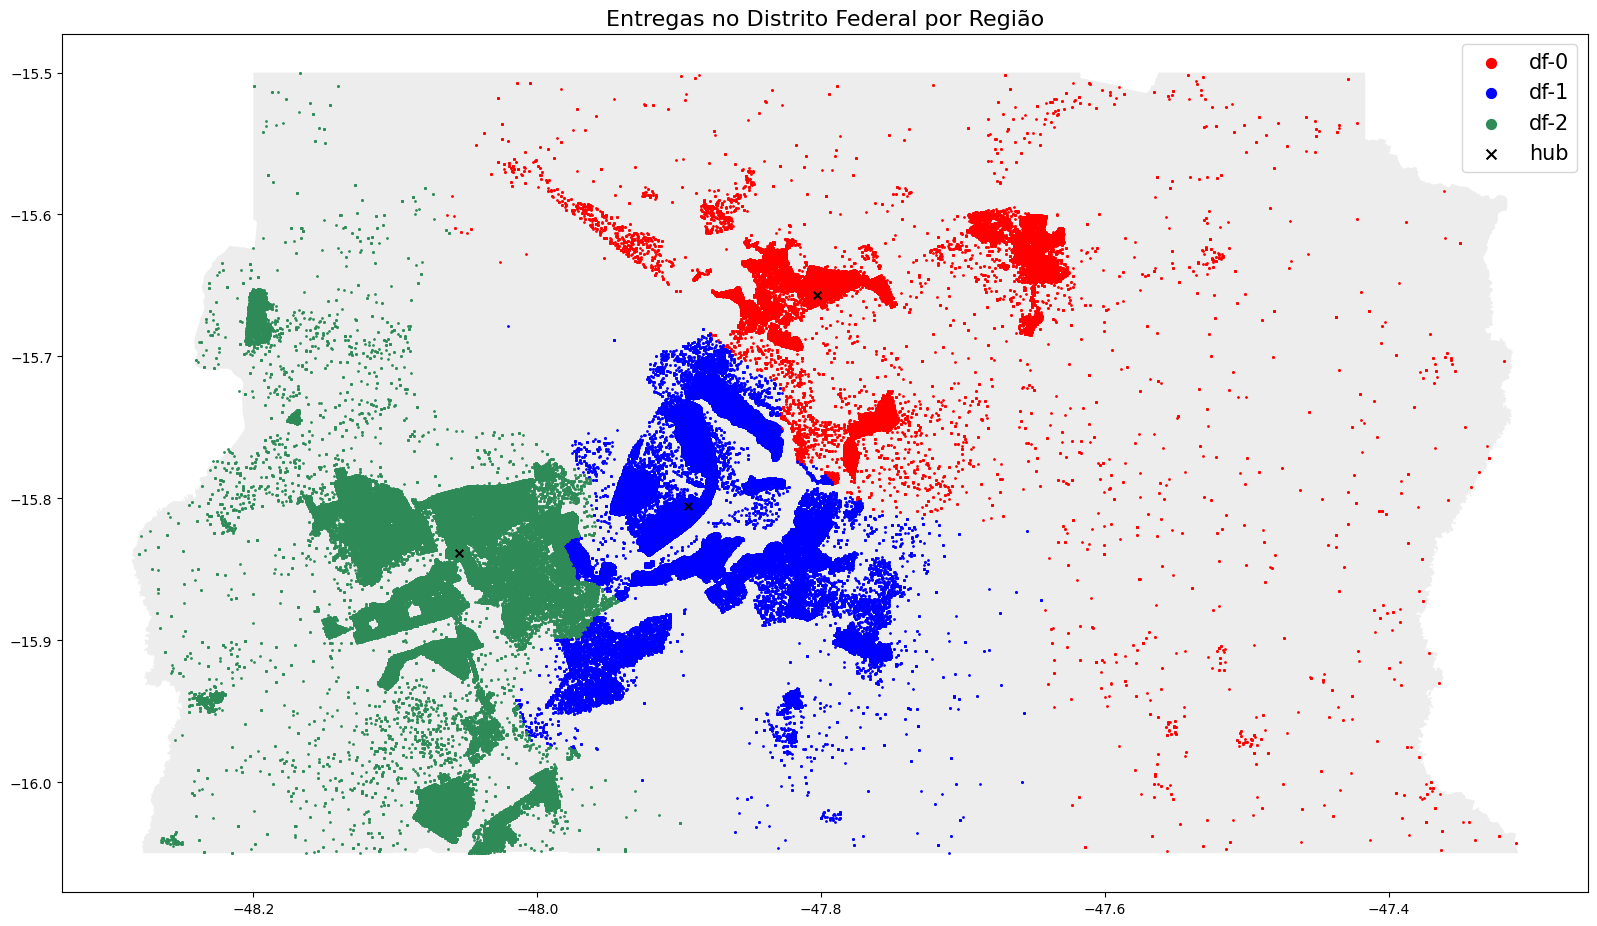

In [ ]:
#Criamos um plot vazio, para que possamos manipular e colocar um plot em cima do outro
#Fazendo a conversão de polegadas para cm
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

#Fazendo o esboço do mapa do distrito federal
mapa.plot(ax=ax, alpha = 0.4, color="lightgrey")

#Plotamos em cima do esboço, os pontos de entregas
geo_deliveries_df.query("region =='df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region =='df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region =='df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

#Plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

#Plotando a legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize":16})
legenda = plt.legend(prop={"size":15})
for handle in legenda.legend_handles:
  handle.set_sizes([50])

**Insights**

As entregas estão corretamente alocadas em seus respectivos hubs, conforme esperado.

Os hubs das regiões 0 e 2 realizam entregas em locais mais distantes do centro, o que pode resultar em tempos e custos de entrega mais elevados, isso sugere a necessidade de estratégias específicas para otimizar as rotas de entrega nessas regiões, visando a eficiência operacional e a satisfação do cliente.

Gráfico de entregas por região

In [ ]:
#Fazendo um novo DataFrame, que iremos utilizar para plotar nosso gráfico
data = pd.DataFrame(deliveries_df[["region","vehicle_capacity"]].value_counts(normalize=True)).reset_index()
data.rename(columns={"proportion":"region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


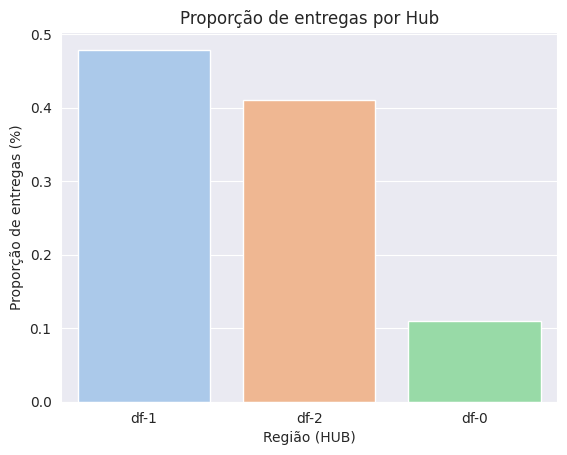

In [ ]:
#Plotando o gráfico de barras, das entregas por HUB
with sns.axes_style("darkgrid"):
  grafico = sns.barplot(data=data, x="region", y="region_percent", hue = "region", errorbar=None, palette="pastel")
  grafico.set(title="Proporção de entregas por Hub", xlabel="Região (HUB)", ylabel="Proporção de entregas (%)")

**Insight gráfico:** Observa-se que a distribuição das entregas está significativamente concentrada nos hubs das regiões 1 e 2, enquanto há uma menor quantidade na região 0. No entanto, a capacidade dos veículos é a mesma em todos os hubs, portanto, torna-se evidente que os veículos da região 0 poderiam ser realocados para atender às regiões com maior volume de tráfego, otimizando assim a eficiência da operação de entrega.